In [29]:
"""
Note that the PyTorch nn module provides 3D convolutions for volumes or videos.
For now though we'll stick to 2D examples.

(3D convolution is used for operating on CT scan data in Part 2)
"""

import torch.nn as nn

conv = nn.Conv2d(3, 16, kernel_size=3) # 3-channel, 3x3 kernel with 16 out channels
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [30]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [31]:
# Reinit cifar2

import torch
from torchvision import datasets
from torchvision import transforms
data_path = "../data/cifar-10/"


class_names = [
    "Airplane",
    "Automobile",
    "Bird",
    "Cat",
    "Deer",
    "Dog",
    "Frog",
    "Horse",
    "Ship",
    "Truck"
]

# Add to dataset transforms
transformed_cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))
    ])
)


transformed_cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))
    ])
)
   

label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']

cifar2 = [
    (img, label_map[label])
    for img, label in transformed_cifar10
    if label in [0, 2]
]


cifar2_val = [
    (img, label_map[label])
    for img, label in transformed_cifar10_val
    if label in [0, 2]
]

In [32]:
# Convolution i/o example

img, _ = cifar2[0]
output = conv(img.unsqueeze(0)) # requires dimensions B x C x H x W
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

Bird after convolution:


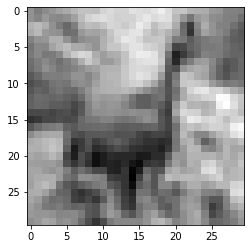

In [33]:
import matplotlib.pyplot as plt

print("Bird after convolution:")

plt.imshow(output[0, 0].detach(), cmap="gray")
plt.show()

In [34]:
"""
Downsampling is common in multi-layer convolution, to ensure content 
initially larger than our kernels can be captured. This can be done using pooling
or specially strided convolutions. We will focus on maxpooling, which has until now
proved most effective.
"""

pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [35]:
# A convolutional model (basic CNN)

model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    # End with fully connected layers
    # Flatten required to transform the 8x8 image up to this point into 512x1 vector
    # We can (and used to have to) forego this by subclassing nn.Module as below,
    # which means abandoning the use of nn.Sequential
    nn.Flatten(),
    nn.Linear(8 * 8 * 8, 32),
    nn.Tanh(),
    nn.Linear(32, 2)
)

model

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Tanh()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Tanh()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten()
  (7): Linear(in_features=512, out_features=32, bias=True)
  (8): Tanh()
  (9): Linear(in_features=32, out_features=2, bias=True)
)

In [36]:
# Quick parameter count

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

Alternative approach to Flatten: subclassing nn.Module.

This is also often required for other operations which the provided modules don't supply.

In [37]:
class Net(nn.Module):
    
    """
    The Net class is equivalent to the nn.Sequential model
    we built earlier in terms of submodules; but by writing
    the forward function explicitly, we can manipulate the
    output of self.pool3 directly and call view on it to turn
    it into a B × N vector (see out.view in the forward() function.
    This is now allowed in an nn.Sequential model, for reasons.
    
    https://github.com/pytorch/pytorch/issues/2486
    """
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out
        

In [38]:
# The functional API (torch.nn.functional) provides counterparts for nn.Modules
# which have no internal state (e.g. parameters). This means modules which do not
# require backprop can be placed in the forward() function

import torch.nn.functional as F

class Net(nn.Module):
    
    """
    A version of the prior Net model utilising the Functional API.
    
    It doesn't matter if we don't use it, but it can make the boilerplate
    more concise as below.
    """
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        # tanh as a general-purpose scientific function remains in the torch namespaces
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [39]:
# Does it run?

model = Net()
model(img.unsqueeze(0))

tensor([[ 0.1287, -0.0501]], grad_fn=<AddmmBackward>)

In [40]:
# Training loop definition

import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            
            outputs = model(imgs)
            
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
            
            loss_train += loss.item()
        
        if epoch == 1 or epoch % 10 == 0:
            print("{} Epoch {}, Training loss {}".format(
                datetime.datetime.now(),
                epoch,
                loss_train / len(train_loader)
            ))

In [41]:
# Dataloader init and run

import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader
)

2020-12-28 19:28:15.799093 Epoch 1, Training loss 0.5612184840023138
2020-12-28 19:28:24.063061 Epoch 10, Training loss 0.3264619844734289
2020-12-28 19:28:33.575720 Epoch 20, Training loss 0.2881455597034685
2020-12-28 19:28:42.629494 Epoch 30, Training loss 0.2683769628690307
2020-12-28 19:28:51.676197 Epoch 40, Training loss 0.2463007071025812
2020-12-28 19:29:00.909399 Epoch 50, Training loss 0.23164321173718022
2020-12-28 19:29:10.005691 Epoch 60, Training loss 0.21244540976680767
2020-12-28 19:29:19.302773 Epoch 70, Training loss 0.19450994841991717
2020-12-28 19:29:28.445251 Epoch 80, Training loss 0.18192931019054476
2020-12-28 19:29:37.636411 Epoch 90, Training loss 0.1691721574800789
2020-12-28 19:29:46.854347 Epoch 100, Training loss 0.15641561186142788


In [42]:
# Measuring accuracy on validation set

val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        print("Accuracy {}: {:.2f}".format(name , correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 0.94
Accuracy val: 0.90


In [45]:
# Saving and loading the model

torch.save(model.state_dict(), data_path + "birds_vs_airplanes_v1.pt")

In [48]:
loaded_model = Net()
loaded_model.load_state_dict(torch.load(data_path + "birds_vs_airplanes_v1.pt"))

loaded_model

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

In [49]:
# Training on GPU requires specification of which device you're using,
# And casting the model to it.

# NOTE: CUDA installation was messed up when this was written. TODO: run this on a working
# GPU machine at some point.

device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
    
    for imgs, labels in train_loader:
        imgs = imgs.to(device=device)
        labels = labels.to(device=device)
        outputs = model(imgs)
        loss = loss_fn(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_train += loss.item()
        
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

Training on device cpu.


In [50]:
train_loader = torch.utils.data.DataLoader(
    cifar2,
    batch_size=64,
    shuffle=True
)

model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2020-12-28 19:43:51.924206 Epoch 100, Training loss 0.004487212296504124
2020-12-28 19:43:51.930103 Epoch 100, Training loss 0.008951313936026993
2020-12-28 19:43:51.935729 Epoch 100, Training loss 0.01344850450564342
2020-12-28 19:43:51.941307 Epoch 100, Training loss 0.017926076794885525
2020-12-28 19:43:51.947223 Epoch 100, Training loss 0.022383221395456107
2020-12-28 19:43:51.952843 Epoch 100, Training loss 0.026810116828626888
2020-12-28 19:43:51.959334 Epoch 100, Training loss 0.031256881489115915
2020-12-28 19:43:51.965012 Epoch 100, Training loss 0.03568487941839133
2020-12-28 19:43:51.970676 Epoch 100, Training loss 0.0400754877716113
2020-12-28 19:43:51.976886 Epoch 100, Training loss 0.044448992249312674
2020-12-28 19:43:51.982446 Epoch 100, Training loss 0.04879681927383326
2020-12-28 19:43:51.988098 Epoch 100, Training loss 0.053110405517991184
2020-12-28 19:43:51.995993 Epoch 100, Training loss 0.05744798889585361
2020-12-28 19:43:52.001740 Epoch 100, Training loss 0.061

2020-12-28 19:43:52.672284 Epoch 100, Training loss 0.43313802218740916
2020-12-28 19:43:52.678264 Epoch 100, Training loss 0.4367838856900573
2020-12-28 19:43:52.683970 Epoch 100, Training loss 0.43959505846545954
2020-12-28 19:43:52.689786 Epoch 100, Training loss 0.44243250398119544
2020-12-28 19:43:52.695634 Epoch 100, Training loss 0.44570846219730986
2020-12-28 19:43:52.701361 Epoch 100, Training loss 0.4496597907725413
2020-12-28 19:43:52.707518 Epoch 100, Training loss 0.45261534080383886
2020-12-28 19:43:52.715238 Epoch 100, Training loss 0.45613659377310684
2020-12-28 19:43:52.721214 Epoch 100, Training loss 0.45887544333555136
2020-12-28 19:43:52.728069 Epoch 100, Training loss 0.46198430467563073
2020-12-28 19:43:52.733699 Epoch 100, Training loss 0.46571903718504937
2020-12-28 19:43:52.743787 Epoch 100, Training loss 0.4690309594011611
2020-12-28 19:43:52.757943 Epoch 100, Training loss 0.4730649167185376
2020-12-28 19:43:52.768715 Epoch 100, Training loss 0.47690100369939

In [55]:
"""
We have the option of casting a model trained on a certain device to another device
before saving its state dict, but it's more concise (particularly if we're not sure
what kind of device we'll next use it on), if we pass the current device used as map_location
when later loading a saved state_dict.
"""

loaded_model = Net().to(device=device)
loaded_model.load_state_dict(
    torch.load(
        data_path + "birds_vs_airplanes_v1.pt",
        map_location=device # Here
    )
)

<All keys matched successfully>